In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

C:\Users\dgdl1\AppData\Local\Temp\ipykernel_30448\3661010288.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm25_m   = pm25.loc[idx].resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_30448\3661010288.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm10_m   = pm10.loc[idx].resample('M').mean()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_30448\3661010288.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asthma_m = asthma.loc[idx].resample('M').sum()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_30448\3661010288.py:66: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
f:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(by

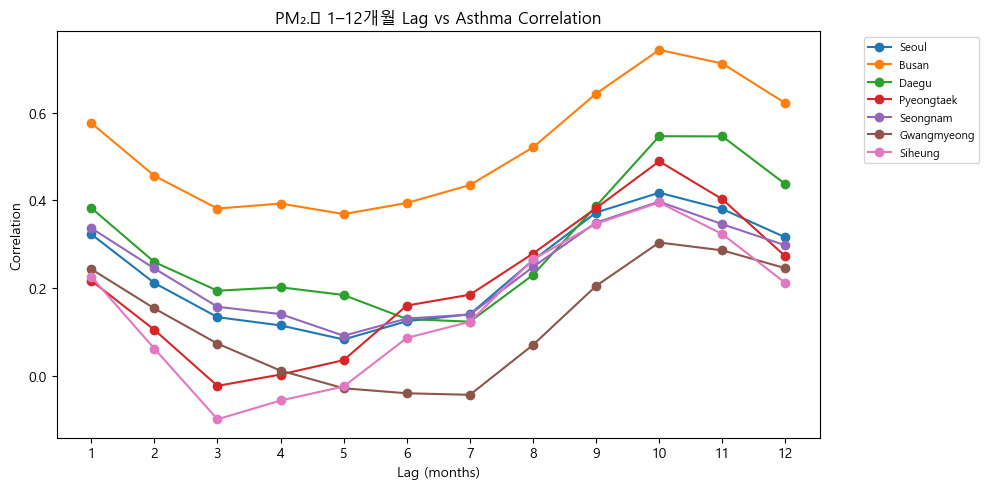

C:\Users\dgdl1\AppData\Local\Temp\ipykernel_30448\3661010288.py:81: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\dgdl1\AppData\Local\Temp\ipykernel_30448\3661010288.py:81: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
f:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8325 (\N{SUBSCRIPT FIVE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
f:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


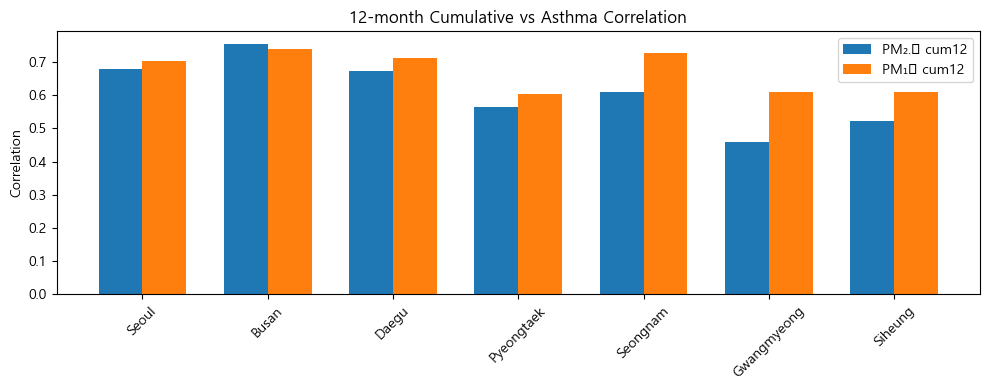

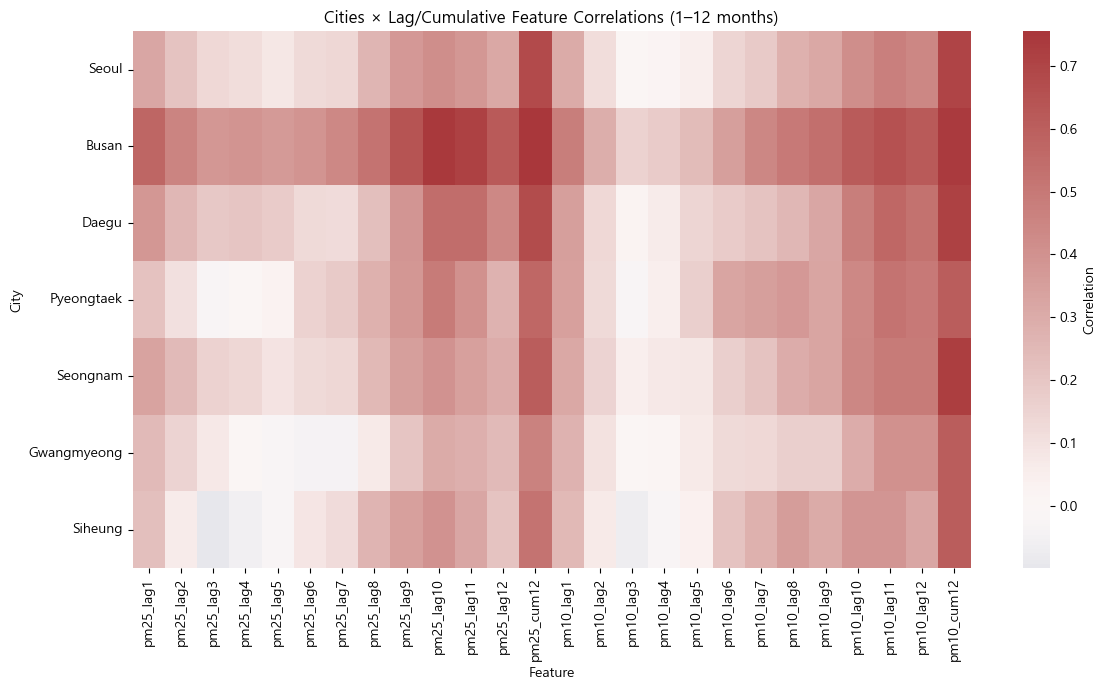

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 데이터 불러오기 & 월별 집계
asthma = pd.read_excel('Asthma_top30_Sum_removed_outliers.xlsx',
                       index_col=0, parse_dates=True)
pm25   = pd.read_excel('pm25_top30_fixed.xlsx',
                       index_col=0, parse_dates=True)
pm10   = pd.read_excel('pm10_top30_fixed.xlsx',
                       index_col=0, parse_dates=True)

# 2) 공통 인덱스 동기화 및 월별 집계
idx      = pm25.index.intersection(asthma.index).intersection(pm10.index)
pm25_m   = pm25.loc[idx].resample('M').mean()
pm10_m   = pm10.loc[idx].resample('M').mean()
asthma_m = asthma.loc[idx].resample('M').sum()

# 3) 분석할 도시 리스트 (세 데이터프레임 모두에 존재하는 도시)
common_cities = set(asthma_m.columns) & set(pm25_m.columns) & set(pm10_m.columns)
cities = ['Seoul','Busan','Daegu','Pyeongtaek','Seongnam','Gwangmyeong','Siheung']
cities = [c for c in cities if c in common_cities]

# 4) lag 및 누적(max_lag=12개월) 설정
max_lag = 12

# 5) 결과 저장용
corr_dict = {}

for city in cities:
    # a) 기본 DataFrame 준비
    df = pd.DataFrame({'asthma': asthma_m[city]})
    
    # b) PM2.5 lag1~lag12, cum12 생성
    for lag in range(1, max_lag+1):
        df[f'pm25_lag{lag}'] = pm25_m[city].shift(lag)
    df[f'pm25_cum{max_lag}'] = pm25_m[city].rolling(window=max_lag, min_periods=1).sum()
    
    # c) PM10 lag1~lag12, cum12 생성
    for lag in range(1, max_lag+1):
        df[f'pm10_lag{lag}'] = pm10_m[city].shift(lag)
    df[f'pm10_cum{max_lag}'] = pm10_m[city].rolling(window=max_lag, min_periods=1).sum()
    
    # d) 결측 제거 및 상관계수 계산
    df_clean = df.dropna()
    corr = df_clean.corr()['asthma'].drop('asthma')
    corr_dict[city] = corr

# 6) DataFrame으로 변환
corr_df = pd.DataFrame(corr_dict)

# 7) PM2.5 지연 상관 라인 플롯
plt.figure(figsize=(10,5))
for city in cities:
    plt.plot(
        range(1, max_lag+1),
        corr_df.loc[[f'pm25_lag{lag}' for lag in range(1, max_lag+1)], city],
        marker='o', label=city
    )
plt.title('PM₂.₅ 1–12개월 Lag vs Asthma Correlation')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.xticks(range(1, max_lag+1))
plt.legend(bbox_to_anchor=(1.05,1), fontsize=8)
plt.tight_layout()
plt.show()

# 8) 누적 12개월 상관 막대플롯 (PM2.5 vs PM10)
plt.figure(figsize=(10,4))
x = np.arange(len(cities))
width = 0.35
pm25_cum = corr_df.loc[f'pm25_cum{max_lag}']
pm10_cum = corr_df.loc[f'pm10_cum{max_lag}']
plt.bar(x - width/2, pm25_cum, width, label=f'PM₂.₅ cum{max_lag}')
plt.bar(x + width/2, pm10_cum, width, label=f'PM₁₀ cum{max_lag}')
plt.xticks(x, cities, rotation=45)
plt.ylabel('Correlation')
plt.title(f'{max_lag}-month Cumulative vs Asthma Correlation')
plt.legend()
plt.tight_layout()
plt.show()

# 9) 전체 도시 × 피처 상관 히트맵
plt.figure(figsize=(12, 7))
sns.heatmap(
    corr_df.T, cmap='vlag', center=0,
    cbar_kws={'label':'Correlation'}
)
plt.title('Cities × Lag/Cumulative Feature Correlations (1–12 months)')
plt.xlabel('Feature')
plt.ylabel('City')
plt.tight_layout()
plt.show()
